Author: Rene Pickhardt

This notebook investigates several things: 

* [Done] how often and far does the max_flow / min_cut diviate from the payment pairs existing incoming and outgoing liquidity 
* [X] Given a twosplit what is the best split ratio? 
* [X] How do various discussed splitting strategies behave?

In [66]:
import json
import networkx as nx
import random
import matplotlib.pyplot as plt
import math
log = math.log2

## Setup and data import

In [7]:
def import_channel_graph():
    # retrieve this by: lightning-cli listchannels > listchannels.json
    f = open("listchannels.json")
    jsn = json.load(f)
    G = nx.Graph()
    for channel in jsn["channels"]:
        src = channel["source"]
        dest = channel["destination"]
        cap = int(channel["satoshis"])
        G.add_edge(src,dest,cap=cap)
    return G

channel_graph = import_channel_graph()

In [46]:
def create_balanced_graph(channel_graph,p=0):
    """p is the probability that the channel is onsided. Thus the default p=0 creates a uniform distribution"""
    funded_network = nx.DiGraph()
    for src,dest in channel_graph.edges():
        cap = channel_graph[src][dest]["cap"]
        bal = None
        if random.random()>=p:
            bal = random.randint(0,cap)
        else:
            if random.random()>0.5:
                bal=0
            else:
                bal=cap
        funded_network.add_edge(src,dest,cap=cap,capacity=bal)
        funded_network.add_edge(dest,src,cap=cap,capacity=cap-bal)
    return funded_network
    
funded_network = create_balanced_graph(channel_graph,p=0.3)

In [47]:
nodes = set(funded_network.nodes)

## Experiment 1: Max Flow vs payment pairs local view: 

We assume a receiving node will not issue an invoice larger than the amount of satoshis it can theoretically receive. Similarly we assume a sending node will not try to pay an invoice if it does not have enough funds to do so. 

We want to see how ofter the maxflow is actually constrained by these two numbers given

* the actual channelGraph with real capacities
* a uniform distribution of balances (as measured before globally)

In [48]:
def compute_inbound(funded_network,node): 
    res = 0
    for n in funded_network.neighbors(node): 
        res += funded_network[n][node]["capacity"]
    return res

def compute_outbound(funded_network,node): 
    res = 0
    for n in funded_network.neighbors(node): 
        res += funded_network[node][n]["capacity"]
    return res


In [55]:
def create_samples(n=3600,p=0):
    res1 = []
    for i in range(n):
        payment_pair = random.sample(nodes,2)
        src, dest = payment_pair
        cut_value, partition = nx.minimum_cut(funded_network, src, dest)
        reachable, non_reachable = partition
        outbound = compute_outbound(funded_network,src)
        inbound = compute_inbound(funded_network, dest)
        print(src[:10],dest[:10], cut_value, outbound, inbound)
        lim = min(outbound,inbound)
        if lim==0: 
            res1.append(1.0)
        else:
            res1.append(cut_value/lim)
        if len(res1)%100 ==0:
            print(len(res1))
    return res1

In [59]:
def create_frequency_timeseries(res):
    # Attention we might have sampled the same payment pair twice!
    f=0
    frequencies = []
    for k,x in enumerate(reversed(res)):
        if x < 1.0:
            f+=1
        frequencies.append(f/(k+1))
    print(f/len(res), f, len(res))
    return frequencies
frequencies_uniform_model = create_frequency_timeseries(create_samples(3600,0))
frequencies_mixed_model = create_frequency_timeseries(create_samples(3600,0.3))

03dd15edf1 0208b5c70e 7081021 21887537 7129434
03db495a7b 0206507b73 91538 91538 1054454
03225e307f 0379ed1af3 40079 40079 680120
02b526c37f 03a4761d92 367208 893904 367208
03c1a8ccc5 021a0266be 893461 42555078 893461
0201fa3ecc 02a02b4987 26596 26596 1505695
033a83907e 0295bd0f3e 198299 11047841 198299
02c10e0f0b 02c197ffa4 569923 569923 60969242
03ee59428b 03c26d296e 0 63216 0
032e3a79dc 021bb42fe0 196126 21873751 196126
0254a73472 02685697ab 1555684 8451150 1555684
03a46347ce 0321146f89 0 347427 0
0333275459 02d21c4174 66623 66623 1366596
037041db9f 037bac010f 65295 163438 65295
03a6680e79 03e1300ab2 531031 5442973 560516
0327e3eed8 03ad6cd751 67914 67914 3674054
025bff93c8 022769c275 187377 187377 387469
03f9ceb115 03594eabc9 238795 2183728 238795
034a1a1c49 02749ad485 28727 2619063 28727
02355a8815 02f9b694a7 65085 65085 515841
03114576a6 02c6c35635 0 37191 0
029bf3edd7 02c4748d7a 5846 9407776 5846
022b8ece90 03e9725720 4257327 5000000 4257327
023c9a852c 024a3af80c 370044 370044 7

03e924d32d 03f5b3dce8 3599 3599 68604
200
0239a2cde4 02b1278809 2749 2749 8928199
03e94ba3cc 03e29d2c63 1576502 1576502 139175424
0363e1d130 021733c0bd 30516 30516 5105877
03284e9570 02ac697d14 106606 106606 458825
0382d277c4 0340564f38 402172 3394835 402172
0272e5a558 024efb83c5 0 603680 1050000
02f10220a7 035179f9a4 96220 119944 96220
02ad921d46 03ddd2ec8b 92954 35466247 92954
022e0cbff0 03031155aa 30285 7931647 30285
037172d211 0350e4c672 0 18772505 0
03865f0191 03c9464b52 217245 217245 503011
03ca79960a 038c33b62c 27186 213537 27186
03eab50cef 03e2d9c37c 6978 474971 6978
03d6f80df7 03d0902de1 20000 2418112 20000
0250e28abd 02edbab1f3 0 0 523629
028c8c79c9 0268060d84 7030 7030 1870606
024409c6a0 026cd1a69f 0 0 10161
03a8d42e18 0330c4004c 18654 18654 2321530
021765b599 0230ef2541 138269 138269 229706
03751c375e 02c2d3836e 64417 152901 64417
0246bc90ed 03b2dc2d57 17407 19171 17407
0322d40e2a 026c6d0ae6 69910 319028 69910
02cac20d1b 02dd2824de 48361 2457089 48361
030018311f 03f84fcf4c 

03cbc9ff6e 028fe767d4 40000 40000 42762
0317f37498 039c396580 57529 83810 57529
03ffd3391c 02b55d46d7 0 1205557 100008
0326f1d067 03f123d4a8 344533 11788259 344533
0380e02956 02c5f4b814 0 5004648 0
02f5329d49 0330974249 0 1395356 0
026b4b19db 0358e25452 0 0 48909
026c72dbf5 0239e4dc85 1273134 1273134 22334066
036bd7addc 02af101323 41579 8413420 41579
03f40efcfc 023f61eb4a 22768 22768 4170820
024a3af80c 0239e16e41 0 7530032 0
03effdecc6 03db39d2f0 56218 154908 56218
0389eea0ac 038ef22960 80671 1305457 80671
02f84f263e 02b6350689 70182 316244 70182
02b3f7a4c4 03cc4dc523 0 0 72387
031971c789 02024415e9 39647 45508 39647
025c5f7f39 03ed28a7c2 535295 535295 5381519
03ee180e8e 03db495a7b 8462 129579737 8462
022d191b8b 02bf9092c4 1238086 1238086 22090441
02b9741160 0253439edf 2303002 3329005 6102609
031a203fcc 028f32a366 66810 66810 81100
03e4641db5 03a0902a21 0 6060 0
030adc00a8 0282f9df1c 24243 83831 24243
035252274f 026ef141cf 8842 8842 35774
030ddceb7a 02bf09f327 16343 16343 3703046
03bbb

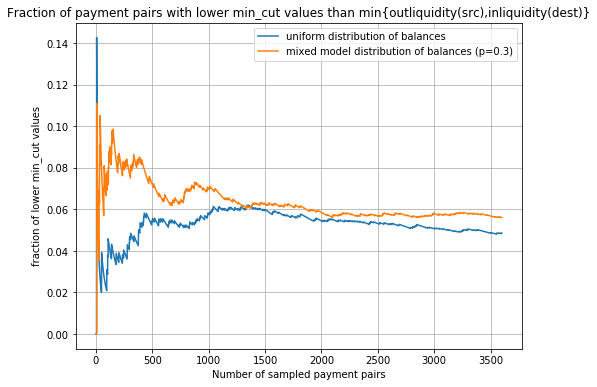

0.05611111111111111 0.04861111111111111


In [58]:
plt.figure(figsize=(8,6))
plt.title("Fraction of payment pairs with lower min_cut values than min{outliquidity(src),inliquidity(dest)}")
plt.plot(frequencies_uniform_model,label="uniform distribution of balances")
plt.plot(frequencies_mixed_model,label="mixed model distribution of balances (p=0.3)")

plt.grid()
plt.xlabel("Number of sampled payment pairs")
plt.ylabel("fraction of lower min_cut values")
plt.legend()
#plt.savefig("../../paper/img/max_flow_fraction.png")
plt.show()

print(f_mixed_model[-1], frequencys[-1])

In [60]:
# it would probably be better to use miletary standard 105D instead of creating a time series

## Experiment 2: optimal splitting ratio

We want to emperically estimate the expected number of attempts needed for various splitting ratios. This is to test the hypothesis that an equidistant splitting for multipart payments works best

In [114]:
def create_probability_graph(amt, channel_graph):
    prob_graph = nx.DiGraph()
    for src, dest in channel_graph.edges():
        cap = channel_graph[src][dest]["cap"]
        if cap <=amt:
            continue
        success_probability = (cap - amt + 1) / (cap + 1)
        log_prob = log(success_probability)
        weight = -1*log_prob 
        #TODO: question could we ignore the amnt and use a weight that is based solely on capacities?
        prob_graph.add_edge(src,dest,weight=weight)
        prob_graph.add_edge(dest,src,weight=weight)
        
    return prob_graph

def update_graph(certain_edges, impossible_edges, prob_graph):
    for src, dest in certain_edges:
        prob_graph[src][dest]["weight"]=0
    for src, dest in impossible_edges:
        print("removing ({},{})".format(src[:10],dest[:10]))
        if prob_graph.has_edge(src,dest):
            prob_graph.remove_edge(src,dest)


def next_hop(path):
    for i in range(1,len(path)):
        src = path[i-1]
        dest = path[i]
        yield (src,dest)

            
def test_path(path, amt, funded_network):
    certain_edges = []
    impossible_edges = []
    
    for src, dest in next_hop(path):
        if funded_network[src][dest]["capacity"] > amt:
            certain_edges.append((src, dest))
        else:
            impossible_edges.append((src,dest))
            break
    return certain_edges, impossible_edges

    
        
def print_path(path,funded_network):
    string = ""
    for src,dest in next_hop(path):
        string+=src[:10]
        string+="--"+str(funded_network[src][dest]["capacity"])+"-->"
    string+=dest[:10]
    print(string)
    
def max_liklihood_pathfinding(src,dest,amt, channel_graph, funded_network):
    prob_graph=create_probability_graph(amt, channel_graph)
    
    impossible_edges=[(src,neighbor) for neighbor in prob_graph.neighbors(src) 
                      if funded_network[src][neighbor]["capacity"]<amt] 
    certain_edges=[(src,neighbor) for neighbor in prob_graph.neighbors(src) 
                   if funded_network[src][neighbor]["capacity"]>=amt]     
    update_graph(certain_edges,impossible_edges,prob_graph)
    
    attempts = 1
    while True:
        path = None
        try: 
            path = nx.shortest_path(prob_graph,src,dest)
        except:
            print("No Path between: {} and {}".format(src[:10],dest[:10]))
            return False, attempts
        certain_edges, impossible_edges = test_path(path, amt, funded_network)
        print_path(path,funded_network)
        if len(impossible_edges)>0:
            #print(certain_edges, impossible_edges)
            update_graph(certain_edges,impossible_edges,prob_graph)
            attempts+=1

        else:
            print("last path worked")
            break
    return True, attempts

In [121]:
def find_optimal_split_ratio(n):
    res = []
    for i in range(n):
        print("PAYMENT PAIR NUMBER: {}".format(i))
        payment_pair = random.sample(nodes,2)
        src, dest = payment_pair
        suc, att = max_liklihood_pathfinding(src, dest, 100000, channel_graph, funded_network)
        res.append((suc,att))
        print(res[-1],"\n")
    return res
res = find_optimal_split_ratio(1000)

PAYMENT PAIR NUMBER: 0
removing (0257bb91a7,0227230b7b)
No Path between: 0257bb91a7 and 0280b55532
(False, 1) 

PAYMENT PAIR NUMBER: 1
removing (03fac7292c,03a503d8e3)
removing (03fac7292c,03cfea6e01)
removing (03fac7292c,0331f80652)
removing (03fac7292c,03902356d2)
removing (03fac7292c,028691404b)
removing (03fac7292c,0219426a5b)
removing (03fac7292c,0297a77f4d)
removing (03fac7292c,02dfdcca40)
removing (03fac7292c,03f360457d)
03fac7292c--493137-->03df3f0a2f--84274-->02ad6fb8d6--0-->03b5b43b3b
removing (03df3f0a2f,02ad6fb8d6)
03fac7292c--441381-->03a5886df6--956279-->02ad6fb8d6--0-->03b5b43b3b
removing (02ad6fb8d6,03b5b43b3b)
03fac7292c--441381-->03a5886df6--561664-->032434517e--232205-->03b5b43b3b
last path worked
(True, 3) 

PAYMENT PAIR NUMBER: 2
removing (02e1f8a072,02cac20d1b)
02e1f8a072--493619-->0215bea618--5949852-->0242a4ae0c--0-->02398b6140--125792-->03bd932f13
removing (0242a4ae0c,02398b6140)
02e1f8a072--493619-->0215bea618--1691045-->024a8228d7--10973761-->02398b6140--1257

NetworkXError: The node 028edfa52a2b6cdfc5ab6849a393c95e5d42687069e1ab5fc299f8d9cddfa8dda9 is not in the digraph.

In [118]:
attemp_rate=[]
total_attempts = 0
successes=0
success_rate = []
for suc,att in res:
    total_attempts+=att
    attemp_rate.append(total_attempts/(len(attemp_rate)+1))
    if suc:
        successes+=1
    success_rate.append(successes/(len(success_rate)+1))

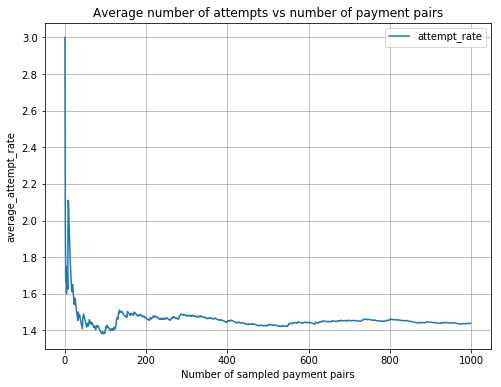

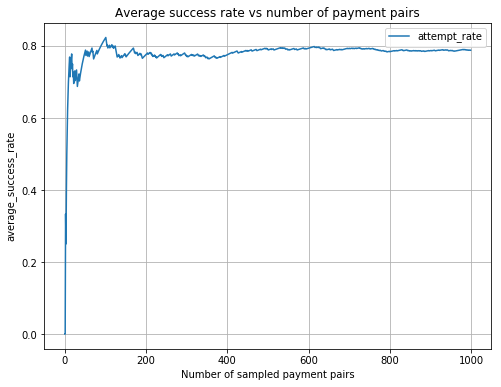

In [120]:
plt.figure(figsize=(8,6))
plt.title("Average number of attempts vs number of payment pairs")
plt.plot(attemp_rate,label="attempt_rate")

plt.grid()
plt.xlabel("Number of sampled payment pairs")
plt.ylabel("average_attempt_rate")
plt.legend()
#plt.savefig("../../paper/img/max_flow_fraction.png")
plt.show()

plt.figure(figsize=(8,6))
plt.title("Average success rate vs number of payment pairs")
plt.plot(success_rate,label="attempt_rate")

plt.grid()
plt.xlabel("Number of sampled payment pairs")
plt.ylabel("average_success_rate")
plt.legend()
#plt.savefig("../../paper/img/max_flow_fraction.png")
plt.show()

## Experiment 3: various splitting strategies

we want to test at least three splitting strategies

### Proposed greedy strategy: 
* compute the theoretic optimal split
* send out onions
* merge failed onions
* update knowledge of the graph
* repeat with the remaining amount

## c-lightning split
* do 10 attempts
* split in half
* repeat each half 

## Binary splitter
* not clear how to implement